Lösung Aufgabe 2

 In Ihrer Fabrik werden auf fünf verschiedenen Maschinen Schrauben produziert. Die Datei DatAn_PKA25_2.csv
 enthält die gemessenen Längen aller produzierten Schrauben, wobei die Spalte der Nummer der produzierenden Maschine entspricht.
 Untersuchen Sie die Messwerte und beantworten Sie insbesondere die folgenden Fragen:

A. Vorverarbeitung 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
path = "DatAn_PKA25_2.csv"

# Datei ist whitespace-getrennt, keine Header-Zeile
df = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
df.columns = [f"Maschine_{i}" for i in range(1, 6)]

print("Shape:", df.shape)
print(df.head())
print(df.tail())


Shape: (25000, 5)
   Maschine_1  Maschine_2  Maschine_3  Maschine_4  Maschine_5
0     48.9392     49.4742     48.4472     48.5586     48.8089
1     49.1081     49.0365     48.9744     48.9943     48.6306
2     48.9219     49.0718     48.7498     49.2695     49.8966
3     49.4421     48.7563     49.2433     49.2323     49.0417
4     49.2517     49.2255     48.9356     49.2263     49.1596
         Maschine_1    Maschine_2    Maschine_3    Maschine_4    Maschine_5
24995  1.135841e+16  1.135977e+16  1.136113e+16  1.136250e+16  1.136386e+16
24996  1.136523e+16  1.136659e+16  1.136796e+16  1.136932e+16  1.137069e+16
24997  1.137205e+16  1.137342e+16  1.137479e+16  1.137615e+16  1.137752e+16
24998  1.137888e+16  1.138025e+16  1.138162e+16  1.138298e+16  1.138435e+16
24999  1.138571e+16  1.138708e+16  1.138845e+16  1.138981e+16  1.139118e+16


Die Messdaten liegen in Matrixform vor, wobei jede Spalte die von einer Maschine produzierten Schraubenlängen enthält.
Bereits durch die erste Sichtung fällt auf, dass die letzten Zeilen extrem große und offensichtlich unrealistische Werte enthalten.



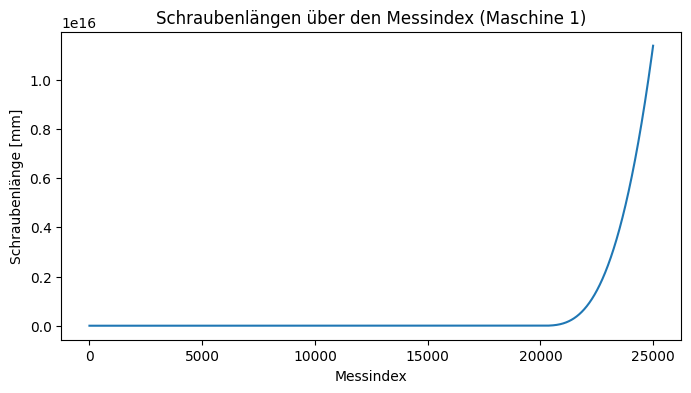

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(df["Maschine_1"])
plt.xlabel("Messindex")
plt.ylabel("Schraubenlänge [mm]")
plt.title("Schraubenlängen über den Messindex (Maschine 1)")
plt.show()


Ab einem Messindex von etwa 20000 nehmen die Messwerte sprunghaft sehr große Werte an, die deutlich außerhalb eines plausiblen Bereichs für Schraubenlängen liegen.
Die gewählte Grenze dient dabei lediglich als grobe Plausibilitätsannahme, da Schraubenlängen typischerweise im Bereich weniger Millimeter bis Zentimeter liegen. Sie wird ausschließlich verwendet, um den offensichtlich fehlerhaften Datenblock zu identifizieren.


In [3]:
mask_bad = (df.abs() > 1000).any(axis=1)   # irgendeine Maschine hat >1000
first_bad = mask_bad.idxmax() if mask_bad.any() else None
n_bad = int(mask_bad.sum())

print("Erste auffällige Zeile (0-basiert):", first_bad)
print("Anzahl auffälliger Zeilen:", n_bad)
print(df.iloc[first_bad-3:first_bad+3])



Erste auffällige Zeile (0-basiert): 20000
Anzahl auffälliger Zeilen: 5000
         Maschine_1    Maschine_2    Maschine_3    Maschine_4    Maschine_5
19997  5.300310e+01  5.942250e+01  7.355440e+01  5.417940e+01  5.007760e+01
19998  4.990170e+01  7.394000e+01  4.274110e+01  6.937470e+01  9.115530e+01
19999  7.028350e+01  3.362650e+01  4.238140e+01  6.802070e+01  4.654690e+01
20000  2.028753e+03  1.016093e+04  2.881952e+04  6.237853e+04  1.152120e+05
20001  1.916938e+05  2.961981e+05  4.330988e+05  6.067699e+05  8.215854e+05
20002  1.081919e+06  1.392146e+06  1.756639e+06  2.179772e+06  2.665919e+06


Die letzten 5000 Messungen werden als fehlerhaft klassifiziert und für die weitere Analyse ausgeschlossen.

In [18]:
df_ok = df.loc[~mask_bad].copy()     # gültige Messwerte
df_bad = df.loc[mask_bad].copy()     # systematisch fehlerhafte Messwerte

print("Rohdaten:")
display(df.describe().T[["mean", "std", "50%", "min", "max"]])

print("\nBereinigte Daten:")
display(df_ok.describe().T[["mean", "std", "50%", "min", "max"]])



Rohdaten:


,mean,std,50%,min,max
Maschine_1,5.694316e+14,1.838963e+15,49.64535,10.0440,1.138571e+16
Maschine_2,5.695227e+14,1.839217e+15,49.54440,10.8545,1.138708e+16
Maschine_3,5.696139e+14,1.839471e+15,49.57345,10.7941,1.138845e+16
Maschine_4,5.697050e+14,1.839725e+15,49.59095,11.3947,1.138981e+16
Maschine_5,5.697961e+14,1.839979e+15,49.56810,10.9472,1.139118e+16



Bereinigte Daten:


,mean,std,50%,min,max
Maschine_1,50.556764,13.993887,49.01510,10.0440,181.2050
Maschine_2,50.286956,13.717796,48.99035,10.8545,211.1635
Maschine_3,50.370306,13.925683,48.99080,10.7941,194.5988
Maschine_4,50.378425,13.849367,49.00760,11.3947,205.5622
Maschine_5,50.282972,13.676546,49.00285,10.9472,184.7216


Der Vergleich zeigt, dass der Mittelwert und die Standardabweichung in den Rohdaten stark durch die fehlerhaften Messungen verzerrt werden, während der Median nahezu unverändert bleibt.
Dies verdeutlicht die hohe Sensitivität des Mittelwertes gegenüber Ausreißern.

Typische Fragestellung: „Produziert meine Maschine noch Schrauben von 50mm Länge…?“ 
→ Das bestätigt den Größenordnungsrahmen: Werte wie 10^3 bis 10^16 sind kein plausibler Messbereich für diese Aufgabe.

In [5]:
df_block_ok = df.loc[~mask_bad].copy()   # 20000 Zeilen
df_block_bad = df.loc[mask_bad].copy()  # 5000 Zeilen


Nach der Identifikation des systematisch fehlerhaften Datenblocks werden die Messdaten in einen plausiblen und einen fehlerhaften Anteil getrennt.
Die gültigen Messwerte (df_block_ok) liegen in einem konsistenten Größenordnungsbereich, während der fehlerhafte Block (df_block_bad) deutlich abweichende Werte aufweist und einer anderen Skala zuzuordnen ist.
Für die weitere Analyse der Schraubenlängen wird daher ausschließlich der bereinigte Datensatz df_block_ok verwendet. Der fehlerhafte Block wird als Dokumentation eines Mess- oder Zuordnungsfehlers separat betrachtet.

Im nächsten Schritt werden innerhalb des plausiblen Datenblocks statistische Ausreißer untersucht. Da keine expliziten Toleranzgrenzen aus der Aufgabenstellung vorgegeben sind, wird hierfür die Boxplot-Regel auf Basis des Interquartilsabstands verwendet. Diese stellt eine etablierte, datengetriebene Methode zur Identifikation auffälliger Werte dar.

                   Q1         Q3        IQR      Lower      Upper  Outlier_n  \
Maschine_1  43.905300  54.983525  11.078225  27.287962  71.600863     1835.0   
Maschine_2  43.622075  54.484525  10.862450  27.328400  70.778200     1895.0   
Maschine_3  43.775075  54.564550  10.789475  27.590863  70.748762     1917.0   
Maschine_4  43.862550  54.618400  10.755850  27.728775  70.752175     1971.0   
Maschine_5  43.681900  54.602850  10.920950  27.300475  70.984275     1887.0   

            Outlier_frac  
Maschine_1       0.09175  
Maschine_2       0.09475  
Maschine_3       0.09585  
Maschine_4       0.09855  
Maschine_5       0.09435  


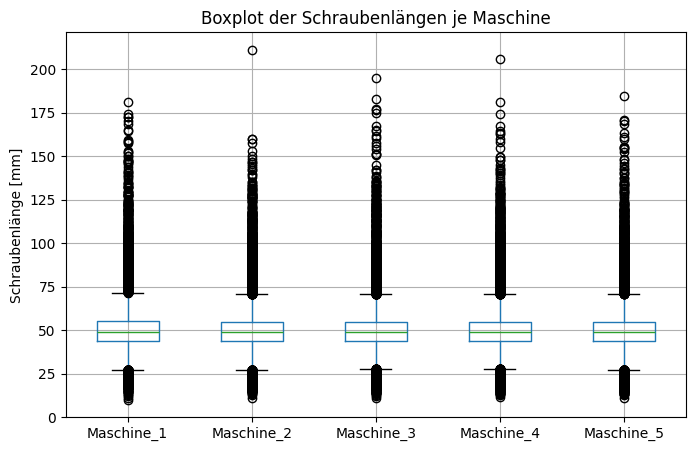

In [6]:
def boxplot_outlier_info(s):
    s = s.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    out = (s < lower) | (s > upper)
    return pd.Series({
        "Q1": q1, "Q3": q3, "IQR": iqr,
        "Lower": lower, "Upper": upper,
        "Outlier_n": int(out.sum()),
        "Outlier_frac": float(out.mean())
    })

out_table = df_block_ok.apply(boxplot_outlier_info)
print(out_table.T)

plt.figure(figsize=(8, 5))
df_block_ok.boxplot()
plt.ylabel("Schraubenlänge [mm]")
plt.title("Boxplot der Schraubenlängen je Maschine")
plt.show()


Die aus den Boxplots abgeleiteten Grenzen liegen für alle Maschinen in einem ähnlichen Bereich, grob zwischen etwa 27 mm und 71 mm. Der Anteil der als Ausreißer klassifizierten Messwerte beträgt je nach Maschine ungefähr 9 % bis 10 %.

Dies zeigt, dass ein nicht vernachlässigbarer Teil der Messungen deutlich vom zentralen Bereich um etwa 49 mm abweicht. Ob es sich dabei um fehlerhafte Messungen, Ausschuss oder um Schrauben einer anderen Variante handelt, lässt sich aus den vorliegenden Daten allein nicht entscheiden.

Aus diesem Grund werden die Ausreißer zunächst lediglich identifiziert und nicht automatisch entfernt. Dieses Vorgehen entspricht der im Skript beschriebenen Vorgehensweise, Ausreißer zunächst zu markieren beziehungsweise als fehlend zu behandeln, sofern keine weiteren fachlichen Informationen vorliegen.

In [7]:
df_clean = df_block_ok.copy()

bounds = {}
for col in df_block_ok.columns:
    s = df_block_ok[col]
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    bounds[col] = (lower, upper)
    df_clean.loc[(s < lower) | (s > upper), col] = np.nan

print("NaNs nach Ausreißer-Markierung:")
print(df_clean.isna().sum())


NaNs nach Ausreißer-Markierung:
Maschine_1    1835
Maschine_2    1895
Maschine_3    1917
Maschine_4    1971
Maschine_5    1887
dtype: int64


1. Geben Sie zunächst Mittelwert, Standardabweichung, Skewness und Kurtosis der Messdaten (nach
 den jeweiligen Maschinen getrennt!) an.

In [8]:
means = df_block_ok.mean()
means_df = means.rename("Mittelwert").to_frame()
means_df


,Mittelwert
Maschine_1,50.556764
Maschine_2,50.286956
Maschine_3,50.370306
Maschine_4,50.378425
Maschine_5,50.282972


In [9]:
stds = df_block_ok.std(ddof=1)  # Stichproben-Standardabweichung (pandas default)
stds_df = stds.rename("Standardabweichung").to_frame()
stds_df

,Standardabweichung
Maschine_1,13.993887
Maschine_2,13.717796
Maschine_3,13.925683
Maschine_4,13.849367
Maschine_5,13.676546


In [10]:
skew = df_block_ok.skew()
skew_df = skew.rename("Skewness").to_frame()
skew_df


,Skewness
Maschine_1,1.791042
Maschine_2,1.610518
Maschine_3,1.807396
Maschine_4,1.718748
Maschine_5,1.631759


In [11]:
kurt = df_block_ok.kurt()
kurt_df = kurt.rename("Kurtosis").to_frame()
kurt_df


,Kurtosis
Maschine_1,8.443975
Maschine_2,7.037238
Maschine_3,8.705320
Maschine_4,8.061227
Maschine_5,7.493070


2. Untersuchen Sie die fünf Verteilungsfunktionen auf Symmetrie. Bei welchen der Verteilungsfunktionen liegt eine Normalverteilung vor? Beschreiben Sie die Abweichung der anderen Verteilungsfunktionen von der Normalverteilung.

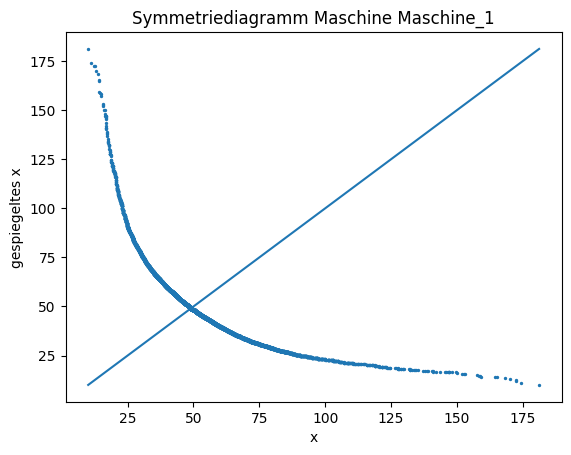

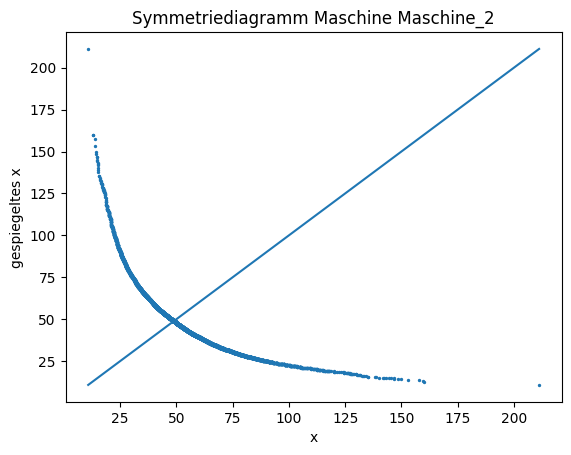

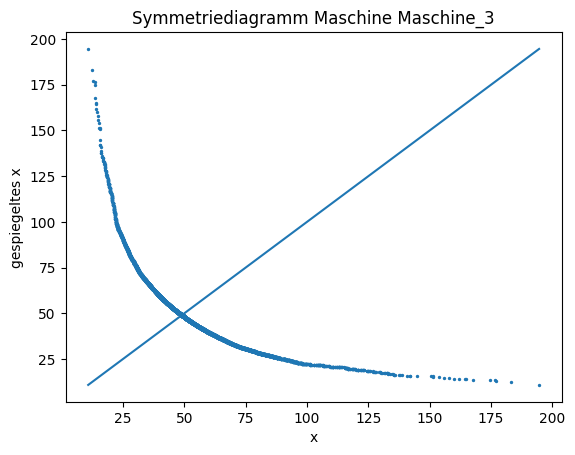

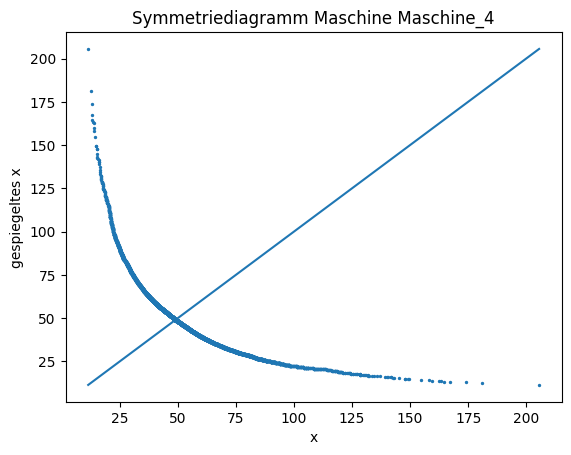

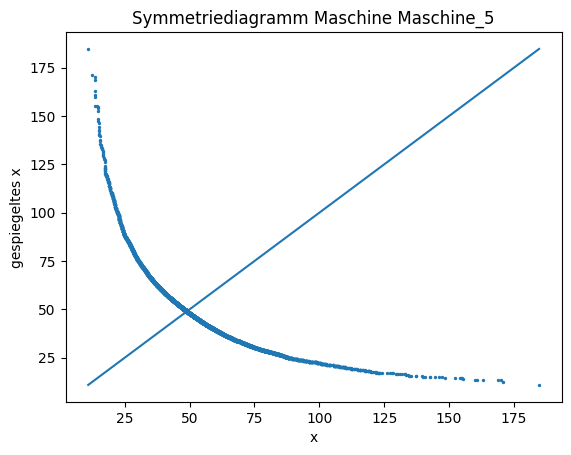

In [12]:
import numpy as np


for col in df_block_ok.columns:
    x = np.sort(df_block_ok[col])
    x_sym = x[::-1]

    plt.figure()
    plt.scatter(x, x_sym, s=2)
    plt.plot([x.min(), x.max()], [x.min(), x.max()])
    plt.title(f"Symmetriediagramm Maschine {col}")
    plt.xlabel("x")
    plt.ylabel("gespiegeltes x")
    plt.show()


            Skewness
Maschine_1  1.791042
Maschine_2  1.610518
Maschine_3  1.807396
Maschine_4  1.718748
Maschine_5  1.631759
            Kurtosis
Maschine_1  8.443975
Maschine_2  7.037238
Maschine_3  8.705320
Maschine_4  8.061227
Maschine_5  7.493070


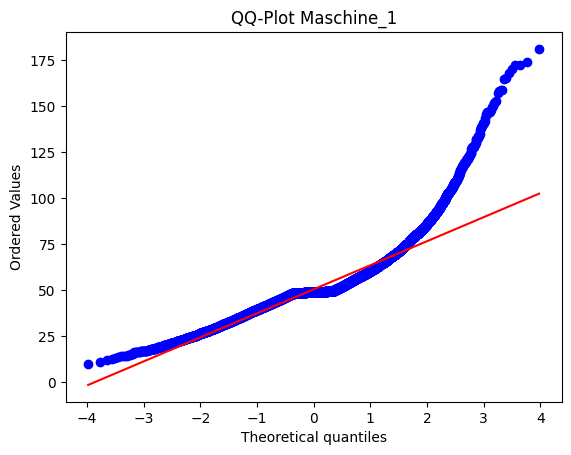

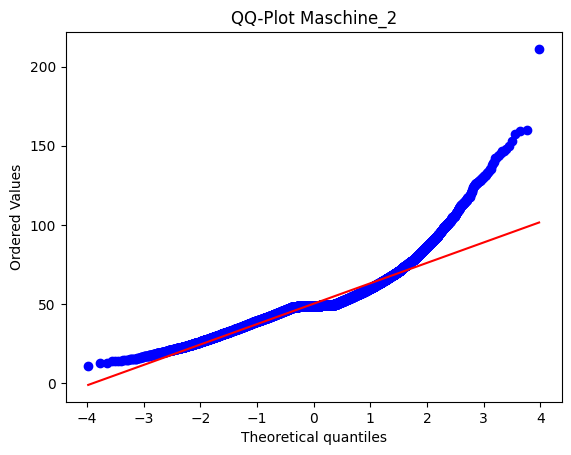

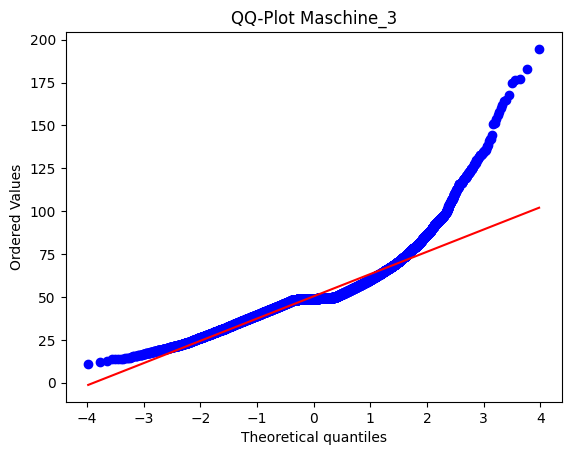

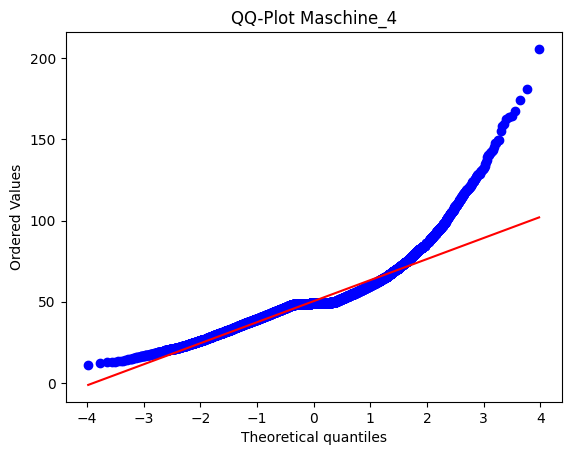

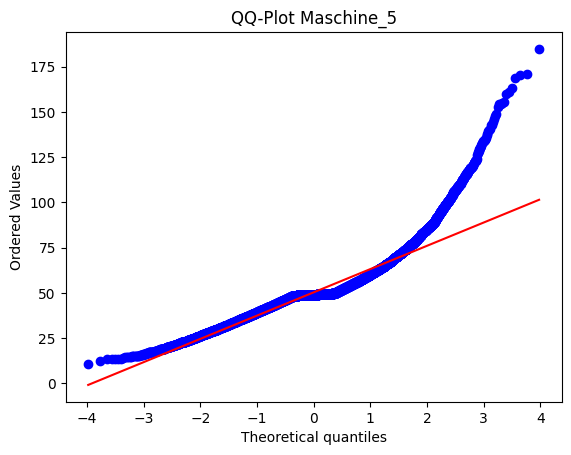

In [13]:
print(skew_df)
print(kurt_df)
from scipy.stats import probplot

for col in df_block_ok.columns:
    plt.figure()
    probplot(df_block_ok[col], dist="norm", plot=plt)
    plt.title(f"QQ-Plot {col}")
    plt.show()


Die Symmetrieuntersuchung zeigt, dass keine der fünf Verteilungsfunktionen symmetrisch ist. Die Symmetriediagramme weisen systematische Abweichungen von der Winkelhalbierenden auf, wobei kleinen Messwerten deutlich größere gespiegelte Werte gegenüberstehen. Dies deutet auf eine ausgeprägte Rechtsschiefe aller Verteilungen hin.

Eine Normalverteilung liegt bei keiner der fünf Maschinen vor. Dies wird durch die QQ-Plots bestätigt: Zwar liegen die Punkte im zentralen Bereich teilweise nahe an der Referenzgeraden, jedoch treten insbesondere in den Randbereichen deutliche systematische Abweichungen auf. Im rechten Rand liegen die Punkte deutlich oberhalb der Geraden, was auf einen schweren rechten Tail hinweist.

Die positive Skewness von etwa 1,7 bestätigt die Rechtsschiefe der Verteilungen, während die hohe Kurtosis von etwa 8 auf deutlich schwerere Tails im Vergleich zur Normalverteilung hindeutet. Die Abweichung von der Normalverteilung äußert sich somit in einer asymmetrischen Verteilung mit stark ausgeprägten extrem großen Werten.

 3. Untersuchen Sie, ob sich die von den verschiedenen Maschinen erzeugten Verteilungsfunktionen
 in ihrer Formvoneinander unterscheiden. Haben zwei der Verteilungsfunktionen die gleiche Form?

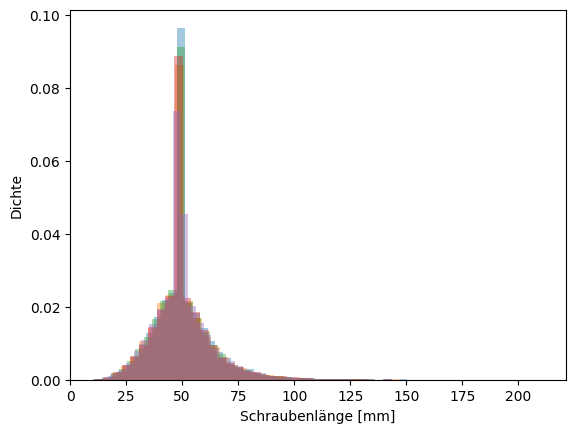

In [14]:
plt.figure()

for col in df_block_ok.columns:
    plt.hist(df_block_ok[col], bins=50, density=True, alpha=0.4)

plt.xlabel("Schraubenlänge [mm]")
plt.ylabel("Dichte")
plt.show()


In [15]:
from scipy.stats import skew, kurtosis

for col in df_block_ok.columns:
    print(col,
          round(skew(df_block_ok[col]), 2),
          round(kurtosis(df_block_ok[col]), 2))


Maschine_1 1.79 8.44
Maschine_2 1.61 7.04
Maschine_3 1.81 8.7
Maschine_4 1.72 8.06
Maschine_5 1.63 7.49
